#  Прогнозирование заказов такси

<b>Цели проекта:</b>  
Построить модель для прогнозирования количества заказов такси на следущий час. 
  
<b>Задачи проекта:</b>
- Загрузить данные и выполнить их ресемплирование по одному часу.
- Проанализировать данные.
- Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
- Проверить данные на тестовой выборке и сделать выводы.

<b>Данные:</b>  
Исторические данные о заказах такси в аэропортах

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time

# вспомогательные методы
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

# для простых моделей
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# для бустинга
from catboost import CatBoostRegressor

In [2]:
# записать файл в data
try: 
    data = pd.read_csv('/datasets/taxi.csv', sep=',')
except:
    data = pd.read_csv('taxi.csv', sep=',')

In [3]:
# открыть файл
data.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [4]:
# изучить файл: метод info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Видим, что у столбца <code>datetime</code> тип данных <i>int</i>, а должен быть <i>datetime</i>, так как это дата.

In [5]:
# изменить тип данных на datetime
data['datetime'] = pd.to_datetime(data['datetime'])
# проверить, что тип данных изменился
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


После изучения файла методом info() можно сделать вывод, что пропусков в данных нет.

In [6]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


После изучения файла методом describe() можно сделать вывод, что выбросов и аномалий нет.

Перезапишем таблицу, установив столбец <code>datetime</code> в качестве индекса.

In [7]:
# установить столбец в качестве индекса
data = data.set_index('datetime')

# проверить
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [8]:
# проверить, в хронологическом ли порядке расположены даты и время
# если порядок соблюдён, атрибут вернёт True, если нет — False
print(data.index.is_monotonic_increasing)

True


Индексы в таблице расположены в хронологическом порядке, менять порядок индексов не требуется.

Выполним ресемплирование по одному часу.

In [9]:
# ресемплировать
data = data.resample('1H').sum()

### Итоги

1. Открыт и изучен файл методами info(), describe().
2. Тип данных в стобце <code>datetime</code> изменён на datetime.
3. Столбец <code>datetime</code> установлен в качестве индекса.
4. Данные уже изначально были расположены в хронологическом порядке.
5. Проведено ресемплирование по одному часу.

## Анализ

Посмотрим на минимальное и максимальное значения времени. То есть узнаем, когда в нашем датасете начали отсчёт времеини, а когда закончили.

In [10]:
# посчитать
start = data.index.min()
end = data.index.max()
total = data.index.max() - data.index.min()

# напечатать
print('Начало:', start)
print('Конец:', end)
print('Всего:', total)

Начало: 2018-03-01 00:00:00
Конец: 2018-08-31 23:00:00
Всего: 183 days 23:00:00


Можем увидеть, что данные собраны за 183 дня и 23 часа. То есть с 1 марта 2018 года по 31 августа.

Построим графики для анализа. Сначала построим график за весь период, а потом построим график за один день.

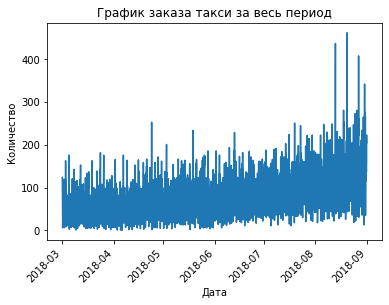

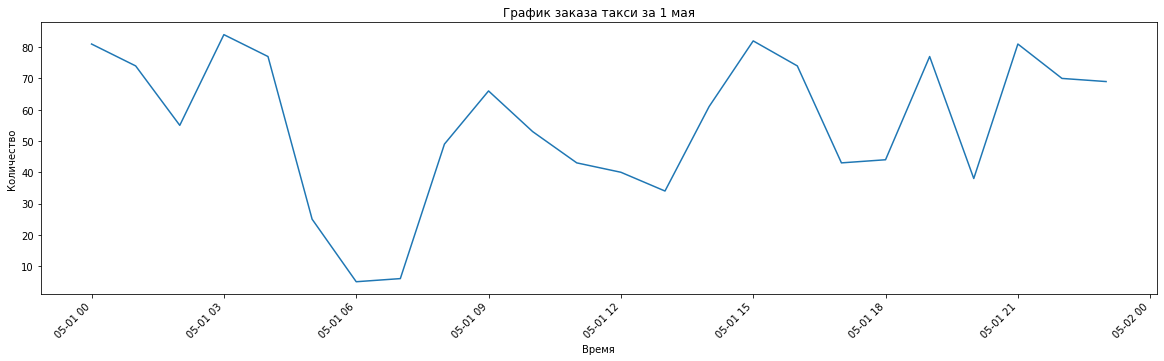

In [11]:
# построить график
plt.plot(data)
plt.title('График заказа такси за весь период')
plt.ylabel('Количество')
plt.xlabel('Дата')
plt.xticks(rotation=45, ha='right')
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

# построить график
plt.plot(data['2018-05-01 00:00:00': '2018-05-01 23:00:00'])
plt.title('График заказа такси за 1 мая')
plt.ylabel('Количество')
plt.xlabel('Время')
plt.xticks(rotation=45, ha='right')
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

Сложно проанализировать приведённые графики и сделать какие-либо выводы.

Найдём скользящее среднее, добавив новый столбец в датасет. Размер окна для скользящего среднего = 100.

In [12]:
# создать новый столбец со скользящим средним
data['rolling_mean'] = data.rolling(100).mean()

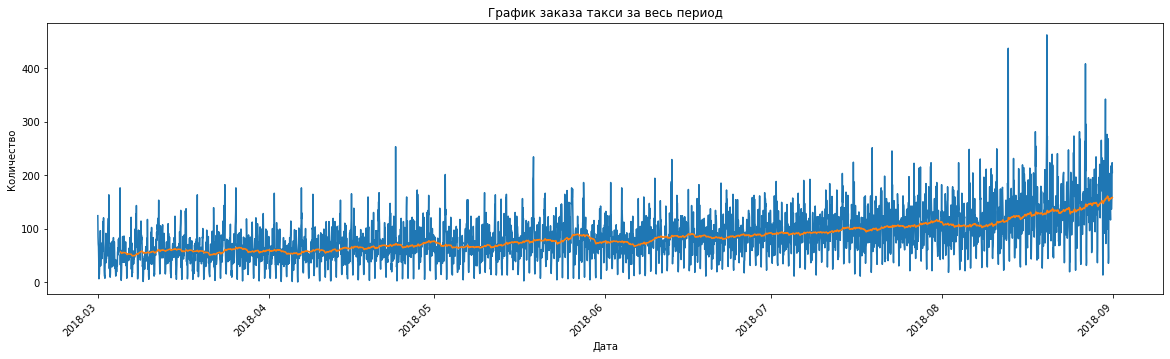

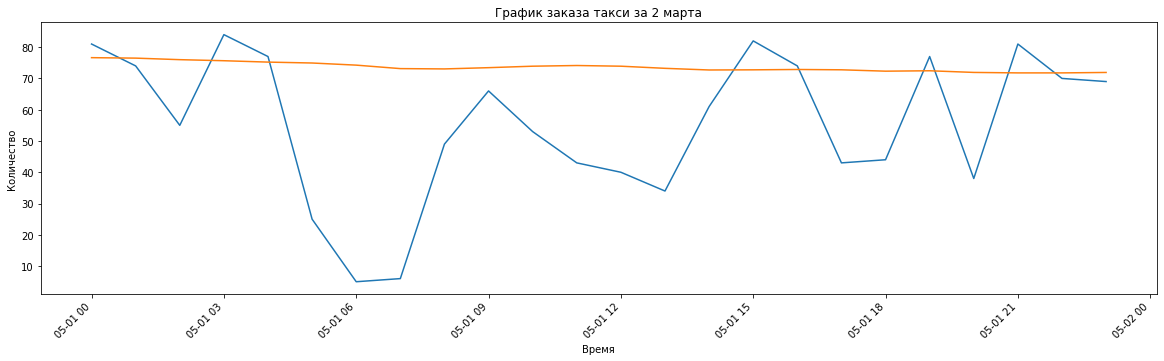

In [13]:
# построить график
plt.plot(data)
plt.title('График заказа такси за весь период')
plt.ylabel('Количество')
plt.xlabel('Дата')
plt.xticks(rotation=45, ha='right')
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

# построить график
plt.plot(data['2018-05-01 00:00:00': '2018-05-01 23:00:00'])
plt.title('График заказа такси за 2 марта')
plt.ylabel('Количество')
plt.xlabel('Время')
plt.xticks(rotation=45, ha='right')
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

С помощью средней скользящей мы можем увидеть восхдящий тренд.

Исследуем тренд, сезонность, остаток декомпозиции.

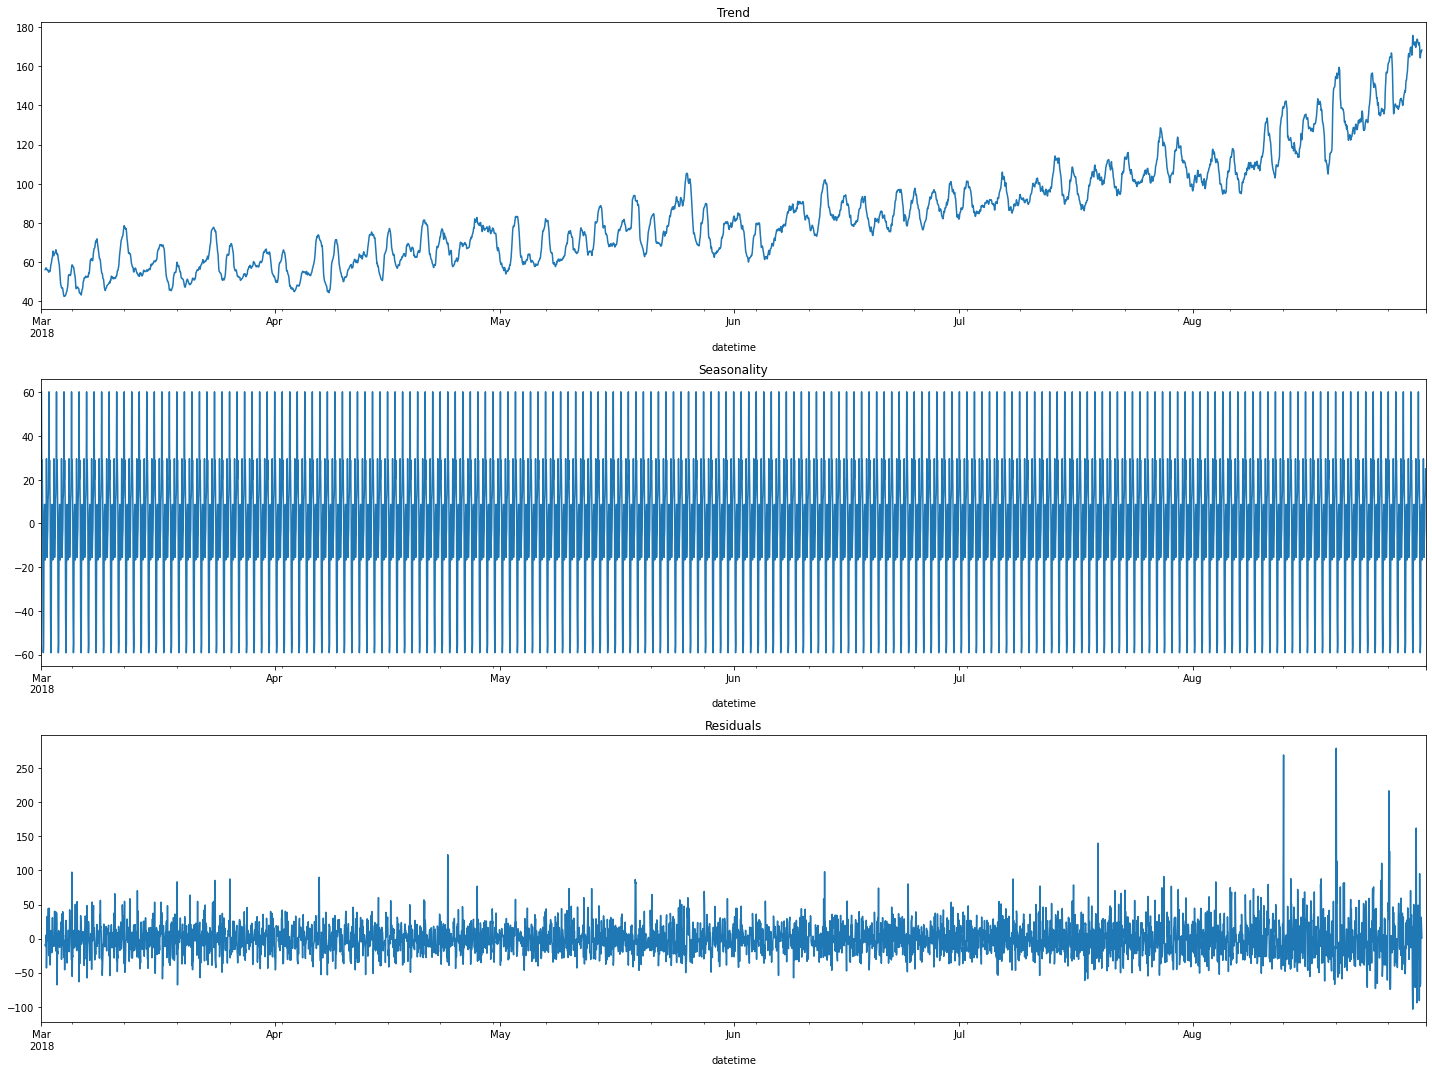

In [14]:
# удалить столбец со скользящим средним для исследования трендов и сезонности
data = data.drop('rolling_mean', axis=1)

decomposed = seasonal_decompose(data) 

plt.figure(figsize=(20, 15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

По графикам мы можем сказать, что остатки необъяснимы, тренд восходящий, то есть количество заказов и пользователей растет, сезонность есть, но на всём промежутке тяжело определить.

Рассмотрим ещё раз графики, но на другом временном интервале.

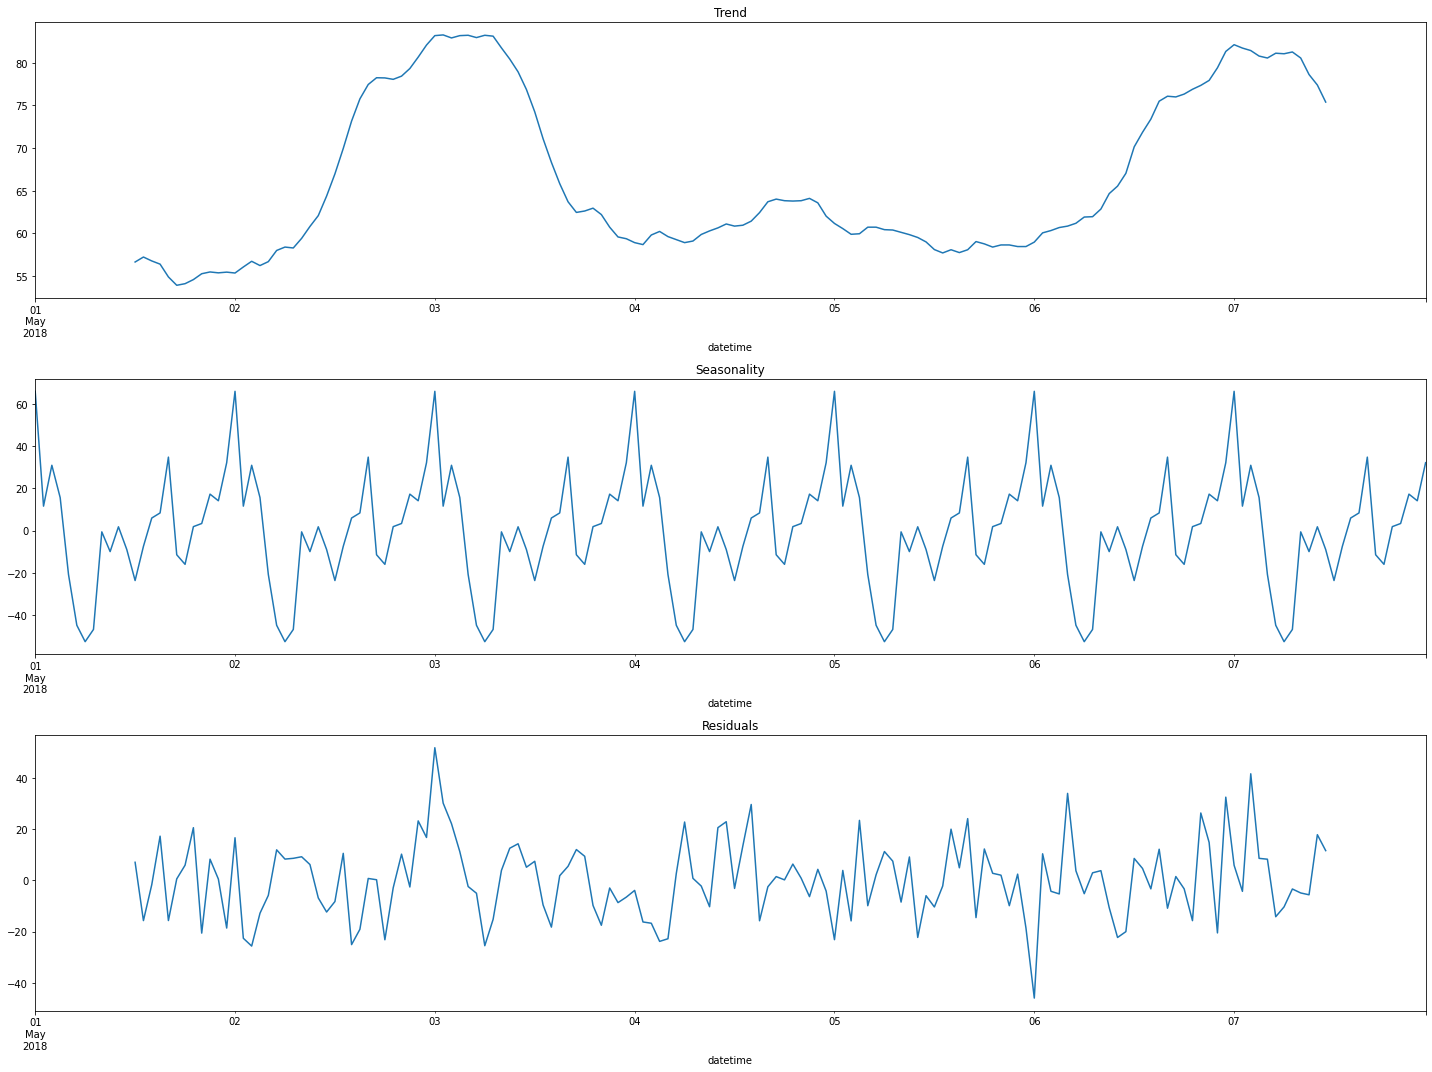

In [15]:
decomposed = seasonal_decompose(data['2018-05-01 00:00:00':'2018-05-07 23:00:00'])

plt.figure(figsize=(20, 15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По графику сезонности мы можем увидеть суточную сезонность: количество заказов резко уменьшается утром, к полуночи количество заказов достигает максимума.

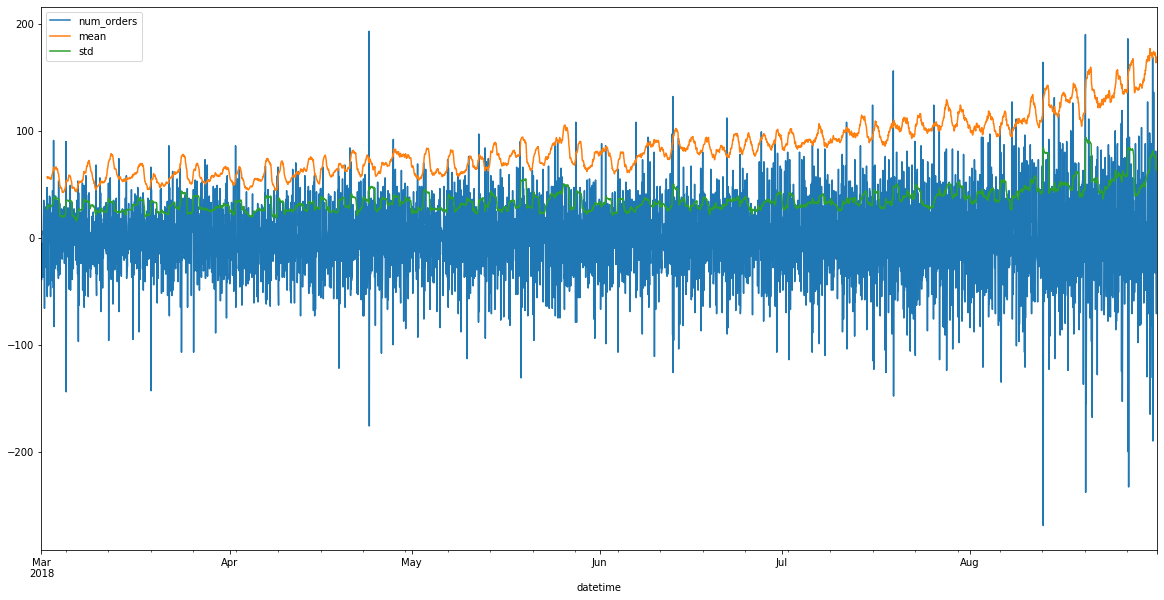

In [16]:
data_shift = data - data.shift()
data_shift['mean'] = data['num_orders'].rolling(24).mean()
data_shift['std'] = data['num_orders'].rolling(24).std()
data_shift.plot(figsize=(20, 10));

Временной ряд нельзя назвать стационарным, потому что у него меняется среднее значение и стандартное отклонение. 

### Итоги

1. Данные в исходном датасете собраны за 183 дня и 23 часа (с 1 марта 2018 года по 31 августа).
2. По графикам мы можем сказать, что остатки необъяснимы, тренд восходящий, то есть количество заказов и пользователей растет, сезонность суточная: количество заказов резко уменьшается утром, к полуночи количество заказов достигает максимума.
3. Временной ряд нельзя назвать стационарным.

## Обучение

Обучим три модели, ориентируясь на метрику RMSE. В качестве моделей используем LinearRegression, RandomForestRegressor и CatBoostRegressor.

In [17]:
# создать функцию для добавления к таблице новых календарных признаков
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [18]:
# применить функцию
# max_lag = 24 (по количеству часов в сутках)
make_features(data, 24, 100)

In [19]:
# создать обучающую и тестовую выборки
train, test = train_test_split(data, shuffle=False, test_size=0.1)

# напечатать минимальные и максимальные значения индексов выборок, 
# чтобы убедиться в корректности деления
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [20]:
# удалить пропуски в обучающей выборке
train = train.dropna()

In [21]:
# выделить в выборках признаки и целевой признак
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [22]:
# функция для rmse
def rmse(target, predicted):
    return mean_absolute_error(target, predicted) ** 0.5

In [23]:
# создать метрику RMSE
rmse_score = make_scorer(rmse, greater_is_better = False)

In [24]:
# создать метрику
neg_root_mean_squared_error = make_scorer(
    mean_squared_error, greater_is_better=False, squared=False
)

#### LinearRegression

In [25]:
%%time
start = time.time()

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
# объявить модель
lr = LinearRegression(copy_X = True, fit_intercept = True, n_jobs = None, normalize = True)
# обучить модель
lr.fit(features_train, target_train)

end = time.time()
t_lr_1 = round(end-start,2)

CPU times: user 142 ms, sys: 37.2 ms, total: 179 ms
Wall time: 175 ms


In [26]:
%%time
start = time.time()

# определить RMSE модели с помощью кросс-валидации
rmse_lr = pd.Series(cross_val_score(lr, features_train, target_train,
                                                scoring = neg_root_mean_squared_error, cv = my_cv)).mean()*(-1)
print('RMSE LinearRegression:', rmse_lr)
print()

end = time.time()
t_lr_2 = round(end-start,2)

RMSE LinearRegression: 28.19876554477997

CPU times: user 173 ms, sys: 430 ms, total: 603 ms
Wall time: 600 ms


#### RandomForestRegressor

In [27]:
%%time
start = time.time()

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
# определить модель модель
rfr = RandomForestRegressor()
# определить набор параметров
forest_parametrs = { 'n_estimators': range(5, 21, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1, 5),
                     'min_samples_split': range(2, 7, 2) }

# применить GridSearchCV
rfr_grid = GridSearchCV(rfr, forest_parametrs, scoring = neg_root_mean_squared_error, cv = my_cv)
rfr_grid.fit(features_train, target_train)

end = time.time()
t_rfr_1 = round(end-start,2)

CPU times: user 2min 51s, sys: 586 ms, total: 2min 52s
Wall time: 2min 52s


In [28]:
%%time
start = time.time()

forest_params = rfr_grid.best_params_
rmse_rfr = rfr_grid.score(features_train, target_train) * (-1)
print(forest_params)
print(rmse_rfr)

print('RMSE RandomForestRegressor =', rmse_rfr)

end = time.time()
t_rfr_2 = round(end-start,2)

{'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 15}
13.758556830968208
RMSE RandomForestRegressor = 13.758556830968208
CPU times: user 13.8 ms, sys: 0 ns, total: 13.8 ms
Wall time: 12.5 ms


#### CatBoostRegressor

In [29]:
%%time
start = time.time()

model_cat = CatBoostRegressor(loss_function="RMSE", iterations=50)
model_cat.fit(features_train, target_train, verbose=10)

end = time.time()
t_cat_1 = round(end-start,2)

Learning rate set to 0.5
0:	learn: 30.7444066	total: 56.7ms	remaining: 2.78s
10:	learn: 22.0323448	total: 118ms	remaining: 420ms
20:	learn: 19.7421216	total: 188ms	remaining: 260ms
30:	learn: 17.8698807	total: 249ms	remaining: 153ms
40:	learn: 16.6291944	total: 310ms	remaining: 68ms
49:	learn: 15.7829889	total: 364ms	remaining: 0us
CPU times: user 346 ms, sys: 8.1 ms, total: 354 ms
Wall time: 1.09 s


In [30]:
%%time
start = time.time()

pred_cat = model_cat.predict(features_train)
rmse_cat = rmse(target_train, pred_cat)

print('RMSE CatBoostRegressor =', rmse_cat)

end = time.time()
t_cat_2 = round(end-start,2)

RMSE CatBoostRegressor = 3.512648610882107
CPU times: user 4.64 ms, sys: 7 µs, total: 4.65 ms
Wall time: 3.12 ms


#### Выбор лучше модели

In [31]:
data_time = [{'Модель': 'RandomForestRegressor', 'Время обучения': t_rfr_1, 
             'Время предсказания': t_rfr_2, 'RMSE': rmse_rfr}, 
             {'Модель': 'LinearRegression', 'Время обучения': t_lr_1, 
              'Время предсказания': t_lr_2, 'RMSE': rmse_lr},
            {'Модель': 'CatBoost', 'Время обучения': t_cat_1, 
             'Время предсказания': t_cat_2, 'RMSE': rmse_cat}]

dframe = pd.DataFrame(data_time, columns =['Модель', 'Время обучения', 'Время предсказания', 'RMSE'])
dframe

,Модель,Время обучения,Время предсказания,RMSE
0,RandomForestRegressor,172.42,0.01,13.758557
1,LinearRegression,0.17,0.60,28.198766
2,CatBoost,1.09,0.00,3.512649


### Итоги

Было проведено обучение трёх моделей: RandomForestRegressor, LinearRegression и CatBoost. Наилучший показатель по RMSE у модели CatBoost. По времени обучения лучший показатель у LinearRegression, но RMSE самый высокий.  
  
Лучшая модель - CatBoostRegressor.

## Тестирование

Проведём тестирование лучшие модели.

In [32]:
%%time
start = time.time()

pred_cat_new = model_cat.predict(features_test)

end = time.time()
t_cat_2 = round(end-start,2)

rmse_cat_new = rmse(target_test, pred_cat_new)
print('RMSE CatBoost = ', rmse_cat_new)
print()

RMSE CatBoost =  5.87278411059481

CPU times: user 3.57 ms, sys: 38 µs, total: 3.61 ms
Wall time: 3.1 ms


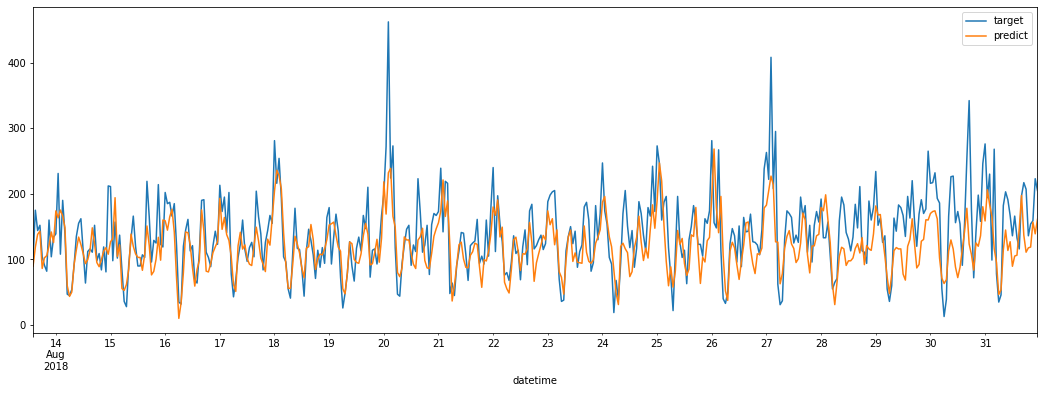

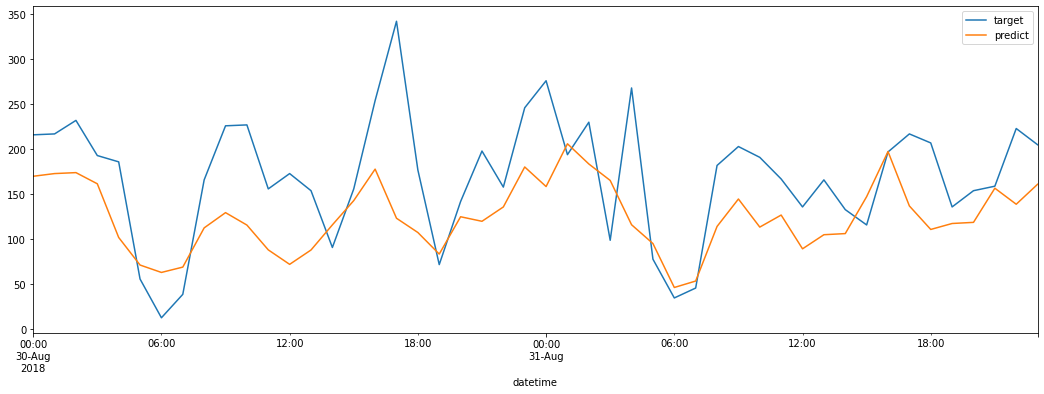

In [33]:
# создать новый фрейм
model_data = pd.DataFrame({"target": target_test, "predict": pred_cat_new})
# создать график 
model_data.plot(figsize=(18, 6));
# создать графки с 30 по 31 августа
model_data['2018-08-30':'2018-08-31'].plot(figsize=(18, 6));

## Выводы

1. <b>Данные изучены.</b>  
2. <b>Проведено ресемплирование по одному часу.</b> 
3. <b>Данные проанализированы</b> 
    - Данные в исходном датасете собраны за 183 дня и 23 часа (с 1 марта 2018 года по 31 августа).
    - По графикам мы можем сказать, что остатки необъяснимы, тренд восходящий, то есть количество заказов и пользователей растет, сезонность суточная: количество заказов резко уменьшается утром, к полуночи количество заказов достигает максимума.
    - Временной ряд нельзя назвать стационарным.
4. <b>Лучшей моделью по критериям (время обучения, время предсказания, RMSE) выбрана CatBoostRegressor.</b>